In [1]:
# %% [markdown]
# # Βελτιστοποιημένο Link Prediction Pipeline
# 
# Αυτό το notebook είναι οργανωμένο σε τμήματα που μπορούν να τρέχουν ανεξάρτητα.
# Τα δεδομένα αποθηκεύονται σε cache για γρήγορη επαναχρησιμοποίηση.

# %% [markdown]
# ## 1. Imports και Βασικές Ρυθμίσεις

# %%
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)

import pickle
import xgboost as xgb
from sklearn.decomposition import PCA
from sklearn.metrics import roc_auc_score, accuracy_score, classification_report, log_loss
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import StandardScaler
import gc
import os
from contextlib import contextmanager
import joblib
from pathlib import Path
import time

import numpy as np
import pandas as pd

# ===== ΡΥΘΜΙΣΗ CACHE DIRECTORY =====
# Αλλαγή εδώ για να ορίσεις το δικό σου path
CACHE_BASE_DIR = "D:"  # Άλλαξε αυτό στο δικό σου δίσκο
CACHE_DIR = Path(CACHE_BASE_DIR) / "NLP_Cache"
CACHE_DIR.mkdir(exist_ok=True, parents=True)

print(f"✓ Imports loaded successfully")
print(f"📁 Cache directory: {CACHE_DIR}")
print(f"🖥️  XGBoost version: {xgb.__version__}")

# Έλεγχος για CUDA availability
try:
    import subprocess
    result = subprocess.run(['nvidia-smi'], capture_output=True, text=True)
    if result.returncode == 0:
        print("🚀 CUDA available for XGBoost")
    else:
        print("⚠️  CUDA not detected, will use CPU")
except:
    print("⚠️  CUDA not detected, will use CPU")

# %% [markdown]
# ## 2. Utility Functions

# %%
@contextmanager
def memory_cleanup():
    """Context manager για αυτόματο καθάρισμα μνήμης"""
    try:
        yield
    finally:
        gc.collect()

def save_to_cache(obj, filename):
    """Αποθήκευση αντικειμένου στο cache"""
    cache_path = CACHE_DIR / filename
    if filename.endswith('.pkl'):
        with open(cache_path, 'wb') as f:
            pickle.dump(obj, f)
    elif filename.endswith('.npy'):
        np.save(cache_path, obj)
    elif filename.endswith('.npz'):
        np.savez_compressed(cache_path, **obj)
    print(f"✓ Saved to cache: {filename}")

def load_from_cache(filename):
    """Φόρτωση αντικειμένου από το cache"""
    cache_path = CACHE_DIR / filename
    if not cache_path.exists():
        return None
    
    if filename.endswith('.pkl'):
        with open(cache_path, 'rb') as f:
            return pickle.load(f)
    elif filename.endswith('.npy'):
        return np.load(cache_path, allow_pickle=True)
    elif filename.endswith('.npz'):
        return dict(np.load(cache_path,allow_pickle=True))
    
def cache_exists(filename):
    """Έλεγχος αν υπάρχει το cache file"""
    return (CACHE_DIR / filename).exists()

print("✓ Utility functions defined")

# %% [markdown]
# ## 3. Memory Efficient Feature Extractor Class

# %%
class MemoryEfficientFeatureExtractor:
    def __init__(self, chunk_size=50000):
        self.chunk_size = chunk_size
        self.scalers = {}
        
    def process_embeddings_chunked(self, emb1, emb2, operation='hadamard'):
        """Επεξεργασία embeddings σε chunks για εξοικονόμηση μνήμης"""
        n_samples = len(emb1)
        result = []
        
        for i in range(0, n_samples, self.chunk_size):
            end_idx = min(i + self.chunk_size, n_samples)
            chunk_emb1 = emb1[i:end_idx]
            chunk_emb2 = emb2[i:end_idx]
            
            if operation == 'hadamard':
                chunk_result = chunk_emb1 * chunk_emb2
            elif operation == 'abs_diff':
                chunk_result = np.abs(chunk_emb1 - chunk_emb2)
            elif operation == 'concat':
                chunk_result = np.hstack([chunk_emb1, chunk_emb2])
            elif operation == 'cosine':
                # Υπολογισμός cosine similarity
                dot_prod = (chunk_emb1 * chunk_emb2).sum(axis=1)
                norm1 = np.linalg.norm(chunk_emb1, axis=1)
                norm2 = np.linalg.norm(chunk_emb2, axis=1)
                chunk_result = (dot_prod / (norm1 * norm2 + 1e-8)).reshape(-1, 1)
            
            result.append(chunk_result)
            del chunk_emb1, chunk_emb2, chunk_result
            gc.collect()
        
        return np.vstack(result)

print("✓ MemoryEfficientFeatureExtractor class defined")

# %% [markdown]
# ## 4. Data Loading Functions (με Cache Support)

# %%
def load_and_optimize_data(force_reload=False):
    """Φόρτωση και βελτιστοποίηση δεδομένων με cache support"""
    
    cache_file = "optimized_data.npz"
    cache_pid_file = "pid_mappings.pkl"
    
    if not force_reload and cache_exists(cache_file) and cache_exists(cache_pid_file):
        print("📁 Loading from cache...")
        data = load_from_cache(cache_file)
        pid_to_idx = load_from_cache(cache_pid_file)
        
        return (data['specter_emb_pca'], pid_to_idx, 
                data['idxs_pid1'], data['idxs_pid2'], 
                pd.DataFrame(data['pairs_data'], columns=['citing', 'cited']))
    
    print("🔄 Loading fresh data...")
    
    print("Φόρτωση SPECTER embeddings...")
    with memory_cleanup():
        specter_emb = np.load(r"D:\NLP\citation_link_prediction\specter_pretrained.npy")
        
        # PCA με λιγότερες διαστάσεις για εξοικονόμηση μνήμης
        pca = PCA(n_components=48, random_state=42)
        specter_emb_pca = pca.fit_transform(specter_emb).astype(np.float16)
        del specter_emb
        gc.collect()
    
    print("Φόρτωση pid mappings...")
    with open(r"D:\NLP\tfidf_xgboost\tfidf_pid_to_idx.pkl", "rb") as f:
        pid_to_idx = pickle.load(f)
    
    print("Φόρτωση citation pairs...")
    pairs_df = pd.read_csv(r"D:/NLP/tfidf_xgboost/split_train_val/citation_pairs_split_train_val.csv")
    idxs_pid1 = pairs_df['citing'].map(pid_to_idx).astype(np.int32).values
    idxs_pid2 = pairs_df['cited'].map(pid_to_idx).astype(np.int32).values
    
    # Save to cache
    cache_data = {
        'specter_emb_pca': specter_emb_pca,
        'idxs_pid1': idxs_pid1,
        'idxs_pid2': idxs_pid2,
        'pairs_data': pairs_df[['citing', 'cited']].values
    }
    save_to_cache(cache_data, cache_file)
    save_to_cache(pid_to_idx, cache_pid_file)
    
    return specter_emb_pca, pid_to_idx, idxs_pid1, idxs_pid2, pairs_df

print("✓ load_and_optimize_data function defined")

# %%
def create_enhanced_features(specter_emb_pca, idxs_pid1, idxs_pid2, force_reload=False):
    """Δημιουργία βελτιωμένων features με cache support"""
    
    cache_file = "specter_features.npy"
    
    if not force_reload and cache_exists(cache_file):
        print("📁 Loading SPECTER features from cache...")
        return load_from_cache(cache_file)
    
    print("🔄 Creating SPECTER features...")
    extractor = MemoryEfficientFeatureExtractor()
    
    X_emb1 = specter_emb_pca[idxs_pid1].astype(np.float32)
    X_emb2 = specter_emb_pca[idxs_pid2].astype(np.float32)
    
    # Χρήση chunked processing
    X_hadamard = extractor.process_embeddings_chunked(X_emb1, X_emb2, 'hadamard')
    X_abs_diff = extractor.process_embeddings_chunked(X_emb1, X_emb2, 'abs_diff')
    X_cosine = extractor.process_embeddings_chunked(X_emb1, X_emb2, 'cosine')
    
    # Πρόσθετα statistical features
    X_dot = (X_emb1 * X_emb2).sum(axis=1).reshape(-1, 1)
    X_l2_dist = np.linalg.norm(X_emb1 - X_emb2, axis=1).reshape(-1, 1)
    
    # Συνδυασμός όλων των SPECTER features
    specter_features = np.hstack([
        X_emb1, X_emb2, X_hadamard, X_abs_diff, X_cosine, X_dot, X_l2_dist
    ]).astype(np.float16)
    
    del X_emb1, X_emb2, X_hadamard, X_abs_diff, X_cosine, X_dot, X_l2_dist
    gc.collect()
    
    # Save to cache
    save_to_cache(specter_features, cache_file)
    
    return specter_features

print("✓ create_enhanced_features function defined")

# %%
def load_w2v_features(idxs_pid1, idxs_pid2, force_reload=False):
    """Φόρτωση και επεξεργασία Word2Vec features με cache support"""
    
    cache_file = "w2v_features.npy"
    
    if not force_reload and cache_exists(cache_file):
        print("📁 Loading W2V features from cache...")
        return load_from_cache(cache_file)
    
    print("🔄 Creating W2V features...")
    
    data = np.load(r'D:\NLP\Features_XL\embeddings_abstracts\abstract_w2v_embeds.npz')
    mean_embeds = data['mean_embeds'].astype(np.float32)
    
    # PCA με λιγότερες διαστάσεις
    pca_w2v = PCA(n_components=24, random_state=42)
    mean_embeds_pca = pca_w2v.fit_transform(mean_embeds).astype(np.float16)
    
    X_w2v1 = mean_embeds_pca[idxs_pid1]
    X_w2v2 = mean_embeds_pca[idxs_pid2]
    
    # Υπολογισμός similarities
    dot_w2v = (X_w2v1 * X_w2v2).sum(axis=1)
    norm1 = np.linalg.norm(X_w2v1, axis=1)
    norm2 = np.linalg.norm(X_w2v2, axis=1)
    cosine_w2v = dot_w2v / (norm1 * norm2 + 1e-8)
    l1_w2v = np.abs(X_w2v1 - X_w2v2).sum(axis=1)
    l2_w2v = np.linalg.norm(X_w2v1 - X_w2v2, axis=1)
    
    # Συνδυασμός features
    w2v_features = np.hstack([
        X_w2v1, X_w2v2,
        X_w2v1 * X_w2v2,  # hadamard
        np.abs(X_w2v1 - X_w2v2),  # abs diff
        dot_w2v.reshape(-1, 1),
        cosine_w2v.reshape(-1, 1),
        l1_w2v.reshape(-1, 1),
        l2_w2v.reshape(-1, 1)
    ]).astype(np.float16)
    
    del mean_embeds, mean_embeds_pca, X_w2v1, X_w2v2
    gc.collect()
    
    # Save to cache
    save_to_cache(w2v_features, cache_file)
    
    return w2v_features

print("✓ load_w2v_features function defined")

# %%
def load_csv_features(force_reload=False):
    """Φόρτωση και βελτιστοποίηση CSV features με cache support"""
    
    cache_file = "csv_features_data.npz"
    
    if not force_reload and cache_exists(cache_file):
        print("📁 Loading CSV features from cache...")
        data = load_from_cache(cache_file)
        return data['X_feats'], data['splits'], data['y']
    
    print("🔄 Loading CSV features...")
    
    df_feat = pd.read_csv(r"D:/NLP/Features_XL/train/full_features_correct_h2_train.csv")
    
    # Επεκταμένη λίστα features
    selected_feats = [
        'citation_G_adamic_adar', 'specter_cosine', 'specter_dot',
        'specter_l1', 'specter_l2', 'author_node2vec_cosine',
        'author_node2vec_dot', 'author_node2vec_l2', 'citation_G_jaccard',
        'citation_G_hub_depressed', 'tfidf_similarity', 'citing_degree',
        'cosine_auth_svd_koz', 'bertopic_features_0', 'bertopic_features_1',
        'bertopic_features_2', 'triangles_through_edge_h2',
    ]
    
    # Επιλογή μόνο των features που υπάρχουν στο dataset
    available_feats = [f for f in selected_feats if f in df_feat.columns]
    print(f"Χρήση {len(available_feats)} από {len(selected_feats)} features")
    
    X_feats = df_feat[available_feats].values.astype(np.float32)
    splits = df_feat['split'].values
    y = df_feat['label'].values.astype(np.int8)
    
    # Save to cache
    cache_data = {
        'X_feats': X_feats,
        'splits': splits, 
        'y': y
    }
    save_to_cache(cache_data, cache_file)
    
    return X_feats, splits, y

print("✓ load_csv_features function defined")

# %% [markdown]
# ## 5. Feature Processing Functions

# %%
def feature_selection_and_scaling(X_combined, y, is_train, n_features=500, force_reload=False):
    """Feature selection και scaling με cache support"""
    
    cache_file = f"processed_features_{n_features}.npz"
    cache_models_file = f"feature_models_{n_features}.pkl"
    
    if not force_reload and cache_exists(cache_file) and cache_exists(cache_models_file):
        print("📁 Loading processed features from cache...")
        data = load_from_cache(cache_file)
        models = load_from_cache(cache_models_file)
        return data['X_train_scaled'], data['X_val_scaled'], models['selector'], models['scaler']
    
    print("🔄 Processing features...")
    
    X_train = X_combined[is_train]
    X_val = X_combined[~is_train]
    y_train = y[is_train]
    
    # Feature selection με SelectKBest
    selector = SelectKBest(f_classif, k=min(n_features, X_combined.shape[1]))
    X_train_selected = selector.fit_transform(X_train, y_train)
    X_val_selected = selector.transform(X_val)
    
    # Scaling
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_selected).astype(np.float32)
    X_val_scaled = scaler.transform(X_val_selected).astype(np.float32)
    
    # Save to cache
    cache_data = {
        'X_train_scaled': X_train_scaled,
        'X_val_scaled': X_val_scaled
    }
    cache_models = {
        'selector': selector,
        'scaler': scaler
    }
    save_to_cache(cache_data, cache_file)
    save_to_cache(cache_models, cache_models_file)
    
    return X_train_scaled, X_val_scaled, selector, scaler

print("✓ feature_selection_and_scaling function defined")

# %% [markdown]
# ## 6. Model Training Functions

# %%
def get_xgboost_params(experiment_name="default"):
    """Παράμετροι XGBoost για διαφορετικά πειράματα"""
    import torch
    
    # Έλεγχος για CUDA availability
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    tree_method = 'hist' if device == 'cuda' else 'hist'
    
    params_dict = {
        "default": {
            'objective': 'binary:logistic',
            'device': device,
            'tree_method': tree_method,
            'max_depth': 8,
            'eta': 0.05,
            'subsample': 0.85,
            'colsample_bytree': 0.85,
            'colsample_bylevel': 0.85,
            'colsample_bynode': 0.85,
            'reg_alpha': 0.1,
            'reg_lambda': 1.0,
            'min_child_weight': 3,
            'gamma': 0.1,
            'max_delta_step': 1,
            'seed': 42,
            'eval_metric': ['logloss', 'auc']
        },
        "fast": {  # Γρήγορο πείραμα
            'objective': 'binary:logistic',
            'device': device,
            'tree_method': tree_method,
            'max_depth': 6,
            'eta': 0.1,
            'subsample': 0.8,
            'colsample_bytree': 0.8,
            'reg_alpha': 0.1,
            'reg_lambda': 1.0,
            'seed': 42,
            'eval_metric': ['logloss', 'auc']
        },
        "deep": {  # Πιο βαθύ μοντέλο
            'objective': 'binary:logistic',
            'device': device,
            'tree_method': tree_method,
            'max_depth': 8,
            'eta': 0.03,
            'subsample': 0.85,
            'colsample_bytree': 0.85,
            'reg_alpha': 0.15,
            'reg_lambda': 2.0,
            'min_child_weight': 3,
            'gamma': 0.1,
            'seed': 42,
            'eval_metric': ['logloss', 'auc']
        }
    }

    
    return params_dict.get(experiment_name, params_dict["default"])

def train_optimized_xgboost(X_train, X_val, y_train, y_val, 
                           experiment_name="default", num_rounds=2000, 
                           early_stopping=50, save_model=True):
    """Εκπαίδευση XGBoost με διάφορες επιλογές"""
    
    print(f"🚀 Training XGBoost - Experiment: {experiment_name}")
    
    params = get_xgboost_params(experiment_name)
    
    # DMatrix creation
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dval = xgb.DMatrix(X_val, label=y_val)
    
    evals_result = {}
    start_time = time.time()
    
    bst = xgb.train(
        params,
        dtrain,
        num_boost_round=num_rounds,
        evals=[(dtrain, 'train'), (dval, 'validation')],
        evals_result=evals_result,
        early_stopping_rounds=early_stopping,
        verbose_eval=25
    )
    
    training_time = time.time() - start_time
    print(f"⏱️ Training completed in {training_time:.1f} seconds")
    
    if save_model:
        model_file = f"xgboost_model_{experiment_name}.json"
        bst.save_model(CACHE_DIR / model_file)
        print(f"💾 Model saved as {model_file}")
    
    return bst, evals_result

def load_trained_model(experiment_name="default"):
    """Φόρτωση προεκπαιδευμένου μοντέλου"""
    model_file = CACHE_DIR / f"xgboost_model_{experiment_name}.json"
    if model_file.exists():
        bst = xgb.Booster()
        bst.load_model(model_file)
        print(f"📁 Loaded model: {experiment_name}")
        return bst
    else:
        print(f"❌ Model not found: {experiment_name}")
        return None

print("✓ Model training functions defined")

# %% [markdown]
# ## 7. Evaluation Functions

# %%
def evaluate_model(bst, X_val, y_val, evals_result=None, model_name="Model"):
    """Comprehensive model evaluation"""
    
    print(f"\n=== Αξιολόγηση {model_name} ===")
    
    # Predictions
    y_pred_proba = bst.predict(xgb.DMatrix(X_val))
    y_pred = (y_pred_proba >= 0.5).astype(int)
    
    # Metrics
    val_logloss = log_loss(y_val, y_pred_proba)
    val_auc = roc_auc_score(y_val, y_pred_proba)
    val_acc = accuracy_score(y_val, y_pred)
    
    print(f"Log Loss: {val_logloss:.5f}")
    print(f"AUC:      {val_auc:.5f}")
    print(f"Accuracy: {val_acc:.5f}")
    
    if val_logloss < 0.09:
        print("🎉 Επιτεύχθηκε στόχος log loss < 0.09!")
    
    # Training history (if available)
    if evals_result:
        best_iter = bst.best_iteration
        print(f"Best iteration: {best_iter}")
        
        for ds in ['train', 'validation']:
            if ds in evals_result:
                ll = evals_result[ds]['logloss'][best_iter]
                auc = evals_result[ds]['auc'][best_iter]
                print(f"{ds.capitalize():12s} | logloss={ll:.5f} | auc={auc:.5f}")
    
    print(f"\nClassification Report:")
    print(classification_report(y_val, y_pred, digits=4))
    
    return {
        'logloss': val_logloss,
        'auc': val_auc,
        'accuracy': val_acc,
        'predictions': y_pred_proba
    }

def show_feature_importance(bst, top_n=10):
    """Εμφάνιση feature importance"""
    importance = bst.get_score(importance_type='weight')
    if not importance:
        print("No feature importance available")
        return
        
    sorted_importance = sorted(importance.items(), key=lambda x: x[1], reverse=True)
    
    print(f"\nTop {top_n} σημαντικότερα features:")
    for i, (feat, score) in enumerate(sorted_importance[:top_n]):
        print(f"{i+1:2d}. {feat}: {score}")
    
    return sorted_importance

print("✓ Evaluation functions defined")

# %% [markdown]
# ## 8. Main Workflow - Load Base Data
# **Τρέχε αυτό το cell μόνο μία φορά ή όταν θες να φορτώσεις fresh data**

# %%
# Φόρτωση βασικών δεδομένων (τρέχει μόνο όταν χρειάζεται)
specter_emb_pca, pid_to_idx, idxs_pid1, idxs_pid2, pairs_df = load_and_optimize_data(force_reload=False)

print(f"✅ Data loaded:")
print(f"   - SPECTER embeddings: {specter_emb_pca.shape}")
print(f"   - Citation pairs: {len(idxs_pid1)}")
print(f"   - PID mappings: {len(pid_to_idx)}")

# %% [markdown]
# ## 9. Feature Creation - Run Once
# **Τρέχε αυτό το cell μόνο όταν θες να δημιουργήσεις features από την αρχή**

# %%
# Δημιουργία features (με cache support)
print("🔄 Creating/Loading features...")

specter_features = create_enhanced_features(specter_emb_pca, idxs_pid1, idxs_pid2, force_reload=False)
w2v_features = load_w2v_features(idxs_pid1, idxs_pid2, force_reload=False)
csv_features, splits, y = load_csv_features(force_reload=False)

print(f"✅ Features ready:")
print(f"   - SPECTER features: {specter_features.shape}")
print(f"   - W2V features: {w2v_features.shape}")
print(f"   - CSV features: {csv_features.shape}")

# Συνδυασμός features
print("🔗 Combining features...")
X_combined = np.hstack([
    specter_features,
    csv_features,
    w2v_features
]).astype(np.float32)

print(f"   - Combined features: {X_combined.shape}")

# Train/Val split
is_train = (splits == 'train')
print(f"   - Train samples: {is_train.sum()}")
print(f"   - Val samples: {(~is_train).sum()}")



✓ Imports loaded successfully
📁 Cache directory: D:NLP_Cache
🖥️  XGBoost version: 3.0.1
🚀 CUDA available for XGBoost
✓ Utility functions defined
✓ MemoryEfficientFeatureExtractor class defined
✓ load_and_optimize_data function defined
✓ create_enhanced_features function defined
✓ load_w2v_features function defined
✓ load_csv_features function defined
✓ feature_selection_and_scaling function defined
✓ Model training functions defined
✓ Evaluation functions defined
📁 Loading from cache...
✅ Data loaded:
   - SPECTER embeddings: (138499, 48)
   - Citation pairs: 2183910
   - PID mappings: 138499
🔄 Creating/Loading features...
📁 Loading SPECTER features from cache...
📁 Loading W2V features from cache...
📁 Loading CSV features from cache...
✅ Features ready:
   - SPECTER features: (2183910, 195)
   - W2V features: (2183910, 100)
   - CSV features: (2183910, 17)
🔗 Combining features...
   - Combined features: (2183910, 312)
   - Train samples: 1965519
   - Val samples: 218391


In [5]:
# %% [markdown]
# ## 10. 🔬 Experiment Zone - Fast Prototyping
# 
# **Αυτή είναι η περιοχή για γρήγορα πειράματα. Μόλις έχεις φορτώσει τα features, μπορείς να τρέχεις διαφορετικά πειράματα εδώ!**

# %%
# === ΠΕΙΡΑΜΑ 1: Γρήγορο baseline με λίγα features ===
print("🧪 Experiment 1: Fast Baseline")

# Feature selection με λίγα features για γρήγορο test
X_train_fast, X_val_fast, selector_fast, scaler_fast = feature_selection_and_scaling(
    X_combined, y, is_train, n_features=200, force_reload=False
)

y_train = y[is_train]
y_val = y[~is_train]

# Γρήγορη εκπαίδευση
bst_fast, evals_fast = train_optimized_xgboost(
    X_train_fast, X_val_fast, y_train, y_val,
    experiment_name="fast", num_rounds=500, early_stopping=20
)

# Αξιολόγηση
results_fast = evaluate_model(bst_fast, X_val_fast, y_val, evals_fast, "Fast Baseline")

🧪 Experiment 1: Fast Baseline
📁 Loading processed features from cache...
🚀 Training XGBoost - Experiment: fast
Using device: cuda
[0]	train-logloss:0.61319	train-auc:0.97950	validation-logloss:0.61338	validation-auc:0.97936
[25]	train-logloss:0.14229	train-auc:0.99108	validation-logloss:0.14484	validation-auc:0.99056
[50]	train-logloss:0.11296	train-auc:0.99204	validation-logloss:0.11713	validation-auc:0.99122
[75]	train-logloss:0.10761	train-auc:0.99256	validation-logloss:0.11295	validation-auc:0.99155
[100]	train-logloss:0.10511	train-auc:0.99288	validation-logloss:0.11147	validation-auc:0.99173
[125]	train-logloss:0.10344	train-auc:0.99311	validation-logloss:0.11065	validation-auc:0.99183
[150]	train-logloss:0.10205	train-auc:0.99329	validation-logloss:0.11010	validation-auc:0.99190
[175]	train-logloss:0.10078	train-auc:0.99346	validation-logloss:0.10962	validation-auc:0.99197
[200]	train-logloss:0.09969	train-auc:0.99361	validation-logloss:0.10930	validation-auc:0.99202
[225]	train

In [6]:
# %%
# === ΠΕΙΡΑΜΑ 2: Περισσότερα features ===
print("🧪 Experiment 2: More Features")

# Περισσότερα features
X_train_more, X_val_more, selector_more, scaler_more = feature_selection_and_scaling(
    X_combined, y, is_train, n_features=400, force_reload=False
)

# Εκπαίδευση με default παραμέτρους
bst_more, evals_more = train_optimized_xgboost(
    X_train_more, X_val_more, y_train, y_val,
    experiment_name="more_features", num_rounds=1000, early_stopping=30
)

# Αξιολόγηση
results_more = evaluate_model(bst_more, X_val_more, y_val, evals_more, "More Features")



🧪 Experiment 2: More Features
🔄 Processing features...
✓ Saved to cache: processed_features_400.npz
✓ Saved to cache: feature_models_400.pkl
🚀 Training XGBoost - Experiment: more_features
Using device: cuda
[0]	train-logloss:0.65144	train-auc:0.98613	validation-logloss:0.65158	validation-auc:0.98585
[25]	train-logloss:0.22520	train-auc:0.99108	validation-logloss:0.22765	validation-auc:0.99042
[50]	train-logloss:0.13838	train-auc:0.99192	validation-logloss:0.14220	validation-auc:0.99111
[75]	train-logloss:0.11493	train-auc:0.99246	validation-logloss:0.12017	validation-auc:0.99144
[100]	train-logloss:0.10724	train-auc:0.99287	validation-logloss:0.11378	validation-auc:0.99165
[125]	train-logloss:0.10363	train-auc:0.99320	validation-logloss:0.11131	validation-auc:0.99182
[150]	train-logloss:0.10114	train-auc:0.99350	validation-logloss:0.10993	validation-auc:0.99197
[175]	train-logloss:0.09892	train-auc:0.99380	validation-logloss:0.10896	validation-auc:0.99210
[200]	train-logloss:0.09694	tr

In [11]:
# %%
# === ΠΕΙΡΑΜΑ 3: Deep model ===
print("🧪 Experiment 3: Deep Model")

# Περισσότερα features
X_train_more, X_val_more, selector_more, scaler_more = feature_selection_and_scaling(
    X_combined, y, is_train, n_features=400, force_reload=False
)

y_train = y[is_train]
y_val = y[~is_train]


# Χρήση των ίδιων features αλλά πιο βαθύ μοντέλο
bst_deep, evals_deep = train_optimized_xgboost(
    X_train_more, X_val_more, y_train, y_val,
    experiment_name="deep", num_rounds=10000, early_stopping=40
)

# Αξιολόγηση
results_deep = evaluate_model(bst_deep, X_val_more, y_val, evals_deep, "Deep Model")


🧪 Experiment 3: Deep Model
📁 Loading processed features from cache...
🚀 Training XGBoost - Experiment: deep
Using device: cuda
[0]	train-logloss:0.66782	train-auc:0.98709	validation-logloss:0.66790	validation-auc:0.98663
[25]	train-logloss:0.32243	train-auc:0.99064	validation-logloss:0.32402	validation-auc:0.99011
[50]	train-logloss:0.19951	train-auc:0.99128	validation-logloss:0.20227	validation-auc:0.99057
[75]	train-logloss:0.14850	train-auc:0.99182	validation-logloss:0.15216	validation-auc:0.99101
[100]	train-logloss:0.12554	train-auc:0.99219	validation-logloss:0.13006	validation-auc:0.99124
[125]	train-logloss:0.11490	train-auc:0.99246	validation-logloss:0.12019	validation-auc:0.99141
[150]	train-logloss:0.10940	train-auc:0.99271	validation-logloss:0.11553	validation-auc:0.99153
[175]	train-logloss:0.10634	train-auc:0.99292	validation-logloss:0.11317	validation-auc:0.99164
[200]	train-logloss:0.10429	train-auc:0.99311	validation-logloss:0.11172	validation-auc:0.99175
[225]	train-lo

In [3]:
# %%     v22222222

# === ΠΕΙΡΑΜΑ 3: Deep model ===
print("🧪 Experiment 3: Deep Model")

# Περισσότερα features
X_train_more, X_val_more, selector_more, scaler_more = feature_selection_and_scaling(
    X_combined, y, is_train, n_features=400, force_reload=False
)

y_train = y[is_train]
y_val = y[~is_train]


# Χρήση των ίδιων features αλλά πιο βαθύ μοντέλο
bst_deep, evals_deep = train_optimized_xgboost(
    X_train_more, X_val_more, y_train, y_val,
    experiment_name="deep", num_rounds=10000, early_stopping=20
)

# Αξιολόγηση
results_deep = evaluate_model(bst_deep, X_val_more, y_val, evals_deep, "Deep Model")


🧪 Experiment 3: Deep Model
📁 Loading processed features from cache...
🚀 Training XGBoost - Experiment: deep
Using device: cuda
[0]	train-logloss:0.66782	train-auc:0.98709	validation-logloss:0.66790	validation-auc:0.98663
[25]	train-logloss:0.32243	train-auc:0.99064	validation-logloss:0.32402	validation-auc:0.99011
[50]	train-logloss:0.19951	train-auc:0.99128	validation-logloss:0.20227	validation-auc:0.99057
[75]	train-logloss:0.14850	train-auc:0.99182	validation-logloss:0.15216	validation-auc:0.99101
[100]	train-logloss:0.12554	train-auc:0.99219	validation-logloss:0.13006	validation-auc:0.99124
[125]	train-logloss:0.11490	train-auc:0.99246	validation-logloss:0.12019	validation-auc:0.99141
[150]	train-logloss:0.10940	train-auc:0.99271	validation-logloss:0.11553	validation-auc:0.99153
[175]	train-logloss:0.10634	train-auc:0.99292	validation-logloss:0.11317	validation-auc:0.99164
[200]	train-logloss:0.10429	train-auc:0.99311	validation-logloss:0.11172	validation-auc:0.99175
[225]	train-lo

In [15]:
# ===================================================================
#  COMPLETE ENHANCED XGBOOST CODE 
# ===================================================================
# Add this complete cell to your notebook

# %% Enhanced imports (add these if missing)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    confusion_matrix, roc_curve, precision_recall_curve,
    average_precision_score
)

# Set plotting style
plt.style.use('default')
sns.set_palette("husl")

# %% Learning Rate Scheduler Class
class LearningRateScheduler:
    """Learning Rate Scheduler for XGBoost"""
    
    def __init__(self, initial_lr=0.1, decay_type='exponential', decay_rate=0.98, 
                 step_size=150, min_lr=0.001, patience=50):
        self.initial_lr = initial_lr
        self.decay_type = decay_type
        self.decay_rate = decay_rate
        self.step_size = step_size
        self.min_lr = min_lr
        self.patience = patience
        self.current_lr = initial_lr
        self.best_score = float('inf')
        self.wait = 0
        
    def update_lr(self, iteration, score=None):
        if self.decay_type == 'exponential':
            self.current_lr = self.initial_lr * (self.decay_rate ** (iteration / self.step_size))
        elif self.decay_type == 'step':
            self.current_lr = self.initial_lr * (self.decay_rate ** (iteration // self.step_size))
        elif self.decay_type == 'adaptive' and score is not None:
            if score < self.best_score:
                self.best_score = score
                self.wait = 0
            else:
                self.wait += 1
                if self.wait >= self.patience:
                    self.current_lr *= self.decay_rate
                    self.wait = 0
                    print(f" Reducing learning rate to {self.current_lr:.6f}")
        
        self.current_lr = max(self.current_lr, self.min_lr)
        return self.current_lr

# %% Best Model Tracker Class
class BestModelTracker:
    """Track and save the best model"""
    
    def __init__(self, save_path, metric='logloss', mode='min'):
        self.save_path = Path(save_path)
        self.metric = metric
        self.mode = mode
        self.best_score = float('inf') if mode == 'min' else float('-inf')
        self.best_iteration = 0
        
    def update(self, model, iteration, validation_score):
        is_better = (validation_score < self.best_score if self.mode == 'min' 
                    else validation_score > self.best_score)
        
        if is_better:
            self.best_score = validation_score
            self.best_iteration = iteration
            model.save_model(self.save_path)
            print(f" New best {self.metric}: {validation_score:.6f} at iteration {iteration}")
        
        return is_better

# %% Enhanced Visualization Function
def create_comprehensive_plots(y_true, y_pred_proba, y_pred, evals_result=None, 
                             model_name="XGBoost Model", save_path=None):
    """Create comprehensive evaluation plots"""
    
    fig = plt.figure(figsize=(20, 15))
    
    # 1. ROC Curve
    plt.subplot(3, 3, 1)
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    auc_score = roc_auc_score(y_true, y_pred_proba)
    
    plt.plot(fpr, tpr, linewidth=2, label=f'ROC (AUC = {auc_score:.4f})')
    plt.plot([0, 1], [0, 1], 'k--', linewidth=1)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 2. Precision-Recall Curve
    plt.subplot(3, 3, 2)
    precision, recall, _ = precision_recall_curve(y_true, y_pred_proba)
    avg_precision = average_precision_score(y_true, y_pred_proba)
    
    plt.plot(recall, precision, linewidth=2, label=f'PR (AP = {avg_precision:.4f})')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 3. Confusion Matrix
    plt.subplot(3, 3, 3)
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    
    # 4. Prediction Distribution
    plt.subplot(3, 3, 4)
    plt.hist(y_pred_proba[y_true == 0], bins=50, alpha=0.7, label='Negative', density=True)
    plt.hist(y_pred_proba[y_true == 1], bins=50, alpha=0.7, label='Positive', density=True)
    plt.xlabel('Predicted Probability')
    plt.ylabel('Density')
    plt.title('Prediction Distribution')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 5. Training History - Log Loss
    if evals_result:
        plt.subplot(3, 3, 5)
        train_logloss = evals_result.get('train', {}).get('logloss', [])
        val_logloss = evals_result.get('validation', {}).get('logloss', [])
        
        if train_logloss and val_logloss:
            plt.plot(train_logloss, label='Training', linewidth=2)
            plt.plot(val_logloss, label='Validation', linewidth=2)
            plt.xlabel('Iteration')
            plt.ylabel('Log Loss')
            plt.title('Training History - Log Loss')
            plt.legend()
            plt.grid(True, alpha=0.3)
        
        # 6. Training History - AUC
        plt.subplot(3, 3, 6)
        train_auc = evals_result.get('train', {}).get('auc', [])
        val_auc = evals_result.get('validation', {}).get('auc', [])
        
        if train_auc and val_auc:
            plt.plot(train_auc, label='Training', linewidth=2)
            plt.plot(val_auc, label='Validation', linewidth=2)
            plt.xlabel('Iteration')
            plt.ylabel('AUC')
            plt.title('Training History - AUC')
            plt.legend()
            plt.grid(True, alpha=0.3)
    
    # 7. Calibration Plot
    plt.subplot(3, 3, 7)
    bin_boundaries = np.linspace(0, 1, 11)
    bin_lowers = bin_boundaries[:-1]
    bin_uppers = bin_boundaries[1:]
    
    ece = 0
    for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):
        in_bin = (y_pred_proba > bin_lower) & (y_pred_proba <= bin_upper)
        prop_in_bin = in_bin.mean()
        
        if prop_in_bin > 0:
            accuracy_in_bin = y_true[in_bin].mean()
            avg_confidence_in_bin = y_pred_proba[in_bin].mean()
            ece += np.abs(avg_confidence_in_bin - accuracy_in_bin) * prop_in_bin
            
            plt.bar(avg_confidence_in_bin, accuracy_in_bin, 
                   width=bin_upper-bin_lower, alpha=0.7, 
                   edgecolor='black', linewidth=1)
    
    plt.plot([0, 1], [0, 1], 'k--', linewidth=2)
    plt.xlabel('Mean Predicted Probability')
    plt.ylabel('Fraction of Positives')
    plt.title(f'Calibration Plot (ECE = {ece:.4f})')
    plt.grid(True, alpha=0.3)
    
    # 8. Class Balance
    plt.subplot(3, 3, 8)
    class_counts = pd.Series(y_true).value_counts().sort_index()
    plt.bar(['Negative', 'Positive'], class_counts.values, alpha=0.7)
    plt.title('Class Distribution')
    plt.ylabel('Count')
    for i, v in enumerate(class_counts.values):
        plt.text(i, v + max(class_counts) * 0.01, f'{v:,}', ha='center', va='bottom')
    
    # 9. Metrics Summary
    plt.subplot(3, 3, 9)
    plt.axis('off')
    
    accuracy = accuracy_score(y_true, y_pred)
    logloss = log_loss(y_true, y_pred_proba)
    
    metrics_text = f"""Model Performance Summary
========================

AUC-ROC: {auc_score:.4f}
Accuracy: {accuracy:.4f}
Log Loss: {logloss:.4f}
Avg Precision: {avg_precision:.4f}

Total Samples: {len(y_true):,}
Positive: {y_true.sum():,} ({y_true.mean()*100:.1f}%)
Negative: {len(y_true)-y_true.sum():,} ({(1-y_true.mean())*100:.1f}%)

ECE: {ece:.4f}"""
    
    plt.text(0.1, 0.9, metrics_text, transform=plt.gca().transAxes, 
             fontsize=11, verticalalignment='top', fontfamily='monospace')
    
    plt.suptitle(f'{model_name} - Comprehensive Evaluation', fontsize=16, fontweight='bold')
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f" Plots saved to: {save_path}")
    
    plt.show()
    return fig

# %% Simple Enhanced Training Function (NO CALLBACK ISSUES)
# %% FIXED - No Retraining Version
def train_enhanced_xgboost_quick(X_train, X_val, y_train, y_val, 
                                experiment_name="enhanced", num_rounds=10000, 
                                early_stopping=50, use_lr_scheduler=True):
    """Quick enhanced XGBoost training without retraining phase"""
    
    print(f"🚀 Enhanced XGBoost Training (Quick): {experiment_name}")
    
    # Parameters
    params = {
        'objective': 'binary:logistic',
        'device': 'cuda',
        'tree_method': 'hist',
        'max_depth': 8,
        'eta': 0.03,
        'subsample': 0.85,
        'colsample_bytree': 0.85,
        'reg_alpha': 0.15,
        'reg_lambda': 2.0,
        'min_child_weight': 5,
        'gamma': 0.1,
        'seed': 42,
        'eval_metric': ['logloss', 'auc']
    }
    
    # Setup directories
    results_dir = CACHE_DIR / "enhanced_results"
    results_dir.mkdir(exist_ok=True, parents=True)
    
    # Create DMatrix
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dval = xgb.DMatrix(X_val, label=y_val)
    
    evals_result = {}
    
    print(f"📊 Training model with early stopping...")
    start_time = time.time()
    
    # Train model normally
    bst = xgb.train(
        params,
        dtrain,
        num_boost_round=num_rounds,
        evals=[(dtrain, 'train'), (dval, 'validation')],
        evals_result=evals_result,
        early_stopping_rounds=early_stopping,
        verbose_eval=100
    )
    
    training_time = time.time() - start_time
    
    # Find best iteration
    val_logloss_history = evals_result['validation']['logloss']
    best_iteration = np.argmin(val_logloss_history)
    best_val_logloss = val_logloss_history[best_iteration]
    
    print(f"\n🏆 Best iteration: {best_iteration}")
    print(f"🎯 Best validation log loss: {best_val_logloss:.6f}")
    
    # Use the existing model but set it to best iteration
    bst.best_iteration = best_iteration
    
    # Save best model (using existing trained model)
    best_model_path = results_dir / f"{experiment_name}_best_model.json"
    bst.save_model(best_model_path)
    print(f"💾 Model saved to: {best_model_path}")
    
    # Generate predictions
    y_pred_proba = bst.predict(dval)
    y_pred = (y_pred_proba >= 0.5).astype(int)
    
    # Calculate final metrics
    final_metrics = {
        'auc': roc_auc_score(y_val, y_pred_proba),
        'accuracy': accuracy_score(y_val, y_pred),
        'logloss': log_loss(y_val, y_pred_proba),
        'avg_precision': average_precision_score(y_val, y_pred_proba),
        'training_time': training_time,
        'best_iteration': best_iteration,
        'best_val_logloss': best_val_logloss
    }
    
    print(f"\n🎯 Final Results:")
    print(f"   AUC: {final_metrics['auc']:.6f}")
    print(f"   Accuracy: {final_metrics['accuracy']:.6f}")
    print(f"   Log Loss: {final_metrics['logloss']:.6f}")
    print(f"   Training Time: {training_time:.1f}s")
    
    # Create visualizations
    plot_save_path = results_dir / f"{experiment_name}_evaluation.png"
    create_comprehensive_plots(
        y_val, y_pred_proba, y_pred, evals_result, 
        f"Enhanced {experiment_name.title()}", plot_save_path
    )
    
    # Cleanup
    del dtrain, dval
    gc.collect()
    
    return bst, evals_result, final_metrics


# %% Enhanced Evaluation Function
def evaluate_model_enhanced(bst, X_val, y_val, evals_result=None, model_name="Model", 
                           create_plots=True):
    """Enhanced model evaluation with comprehensive analysis"""
    
    print(f"\n=== Enhanced Evaluation: {model_name} ===")
    
    # Predictions
    y_pred_proba = bst.predict(xgb.DMatrix(X_val))
    y_pred = (y_pred_proba >= 0.5).astype(int)
    
    # Comprehensive metrics
    val_logloss = log_loss(y_val, y_pred_proba)
    val_auc = roc_auc_score(y_val, y_pred_proba)
    val_acc = accuracy_score(y_val, y_pred)
    avg_precision = average_precision_score(y_val, y_pred_proba)
    
    print(f"🎯 Performance Metrics:")
    print(f"   Log Loss:        {val_logloss:.6f}")
    print(f"   AUC-ROC:         {val_auc:.6f}")
    print(f"   Accuracy:        {val_acc:.6f}")
    print(f"   Avg Precision:   {avg_precision:.6f}")
    
    # Achievement badges
    if val_logloss < 0.09:
        print("🎉 Excellent! Log loss < 0.09 achieved!")
    if val_auc > 0.99:
        print("🏆 Outstanding! AUC > 0.99 achieved!")
    if val_acc > 0.96:
        print("⭐ Great! Accuracy > 96% achieved!")
    
    # Training history
    if evals_result and 'validation' in evals_result:
        val_logloss_history = evals_result['validation']['logloss']
        best_iter = np.argmin(val_logloss_history)
        print(f"\n📊 Training Summary:")
        print(f"   Best iteration:  {best_iter}")
        print(f"   Final log loss:  {val_logloss_history[best_iter]:.6f}")
        
        if 'train' in evals_result:
            train_logloss = evals_result['train']['logloss'][best_iter]
            print(f"   Train log loss:  {train_logloss:.6f}")
    
    # Classification report
    print(f"\n📋 Classification Report:")
    print(classification_report(y_val, y_pred, digits=4))
    
    # Create visualizations
    if create_plots:
        results_dir = CACHE_DIR / "enhanced_results"
        results_dir.mkdir(exist_ok=True, parents=True)
        plot_save_path = results_dir / f"{model_name}_detailed_evaluation.png"
        
        create_comprehensive_plots(
            y_val, y_pred_proba, y_pred, evals_result, 
            model_name, plot_save_path
        )
    
    return {
        'logloss': val_logloss,
        'auc': val_auc,
        'accuracy': val_acc,
        'avg_precision': avg_precision,
        'predictions': y_pred_proba,
        'predictions_binary': y_pred
    }

print(" Complete Enhanced XGBoost Code Loaded Successfully!")
print(" Ready to use: train_enhanced_xgboost_simple() and evaluate_model_enhanced()")

 Complete Enhanced XGBoost Code Loaded Successfully!
 Ready to use: train_enhanced_xgboost_simple() and evaluate_model_enhanced()


'NEW'🧪 Experiment : Deep Model
📁 Loading processed features from cache...
🔄 Using Quick Enhanced Training (No Retraining)
🚀 Enhanced XGBoost Training (Quick): deep_quick
📊 Training model with early stopping...
[0]	train-logloss:0.66782	train-auc:0.98704	validation-logloss:0.66791	validation-auc:0.98660
[100]	train-logloss:0.12562	train-auc:0.99218	validation-logloss:0.13008	validation-auc:0.99124
[200]	train-logloss:0.10446	train-auc:0.99308	validation-logloss:0.11169	validation-auc:0.99176
[300]	train-logloss:0.09886	train-auc:0.99380	validation-logloss:0.10884	validation-auc:0.99211
[400]	train-logloss:0.09475	train-auc:0.99434	validation-logloss:0.10745	validation-auc:0.99231
[500]	train-logloss:0.09131	train-auc:0.99478	validation-logloss:0.10648	validation-auc:0.99246
[600]	train-logloss:0.08849	train-auc:0.99514	validation-logloss:0.10581	validation-auc:0.99256
[700]	train-logloss:0.08592	train-auc:0.99546	validation-logloss:0.10529	validation-auc:0.99263
[800]	train-logloss:0.08

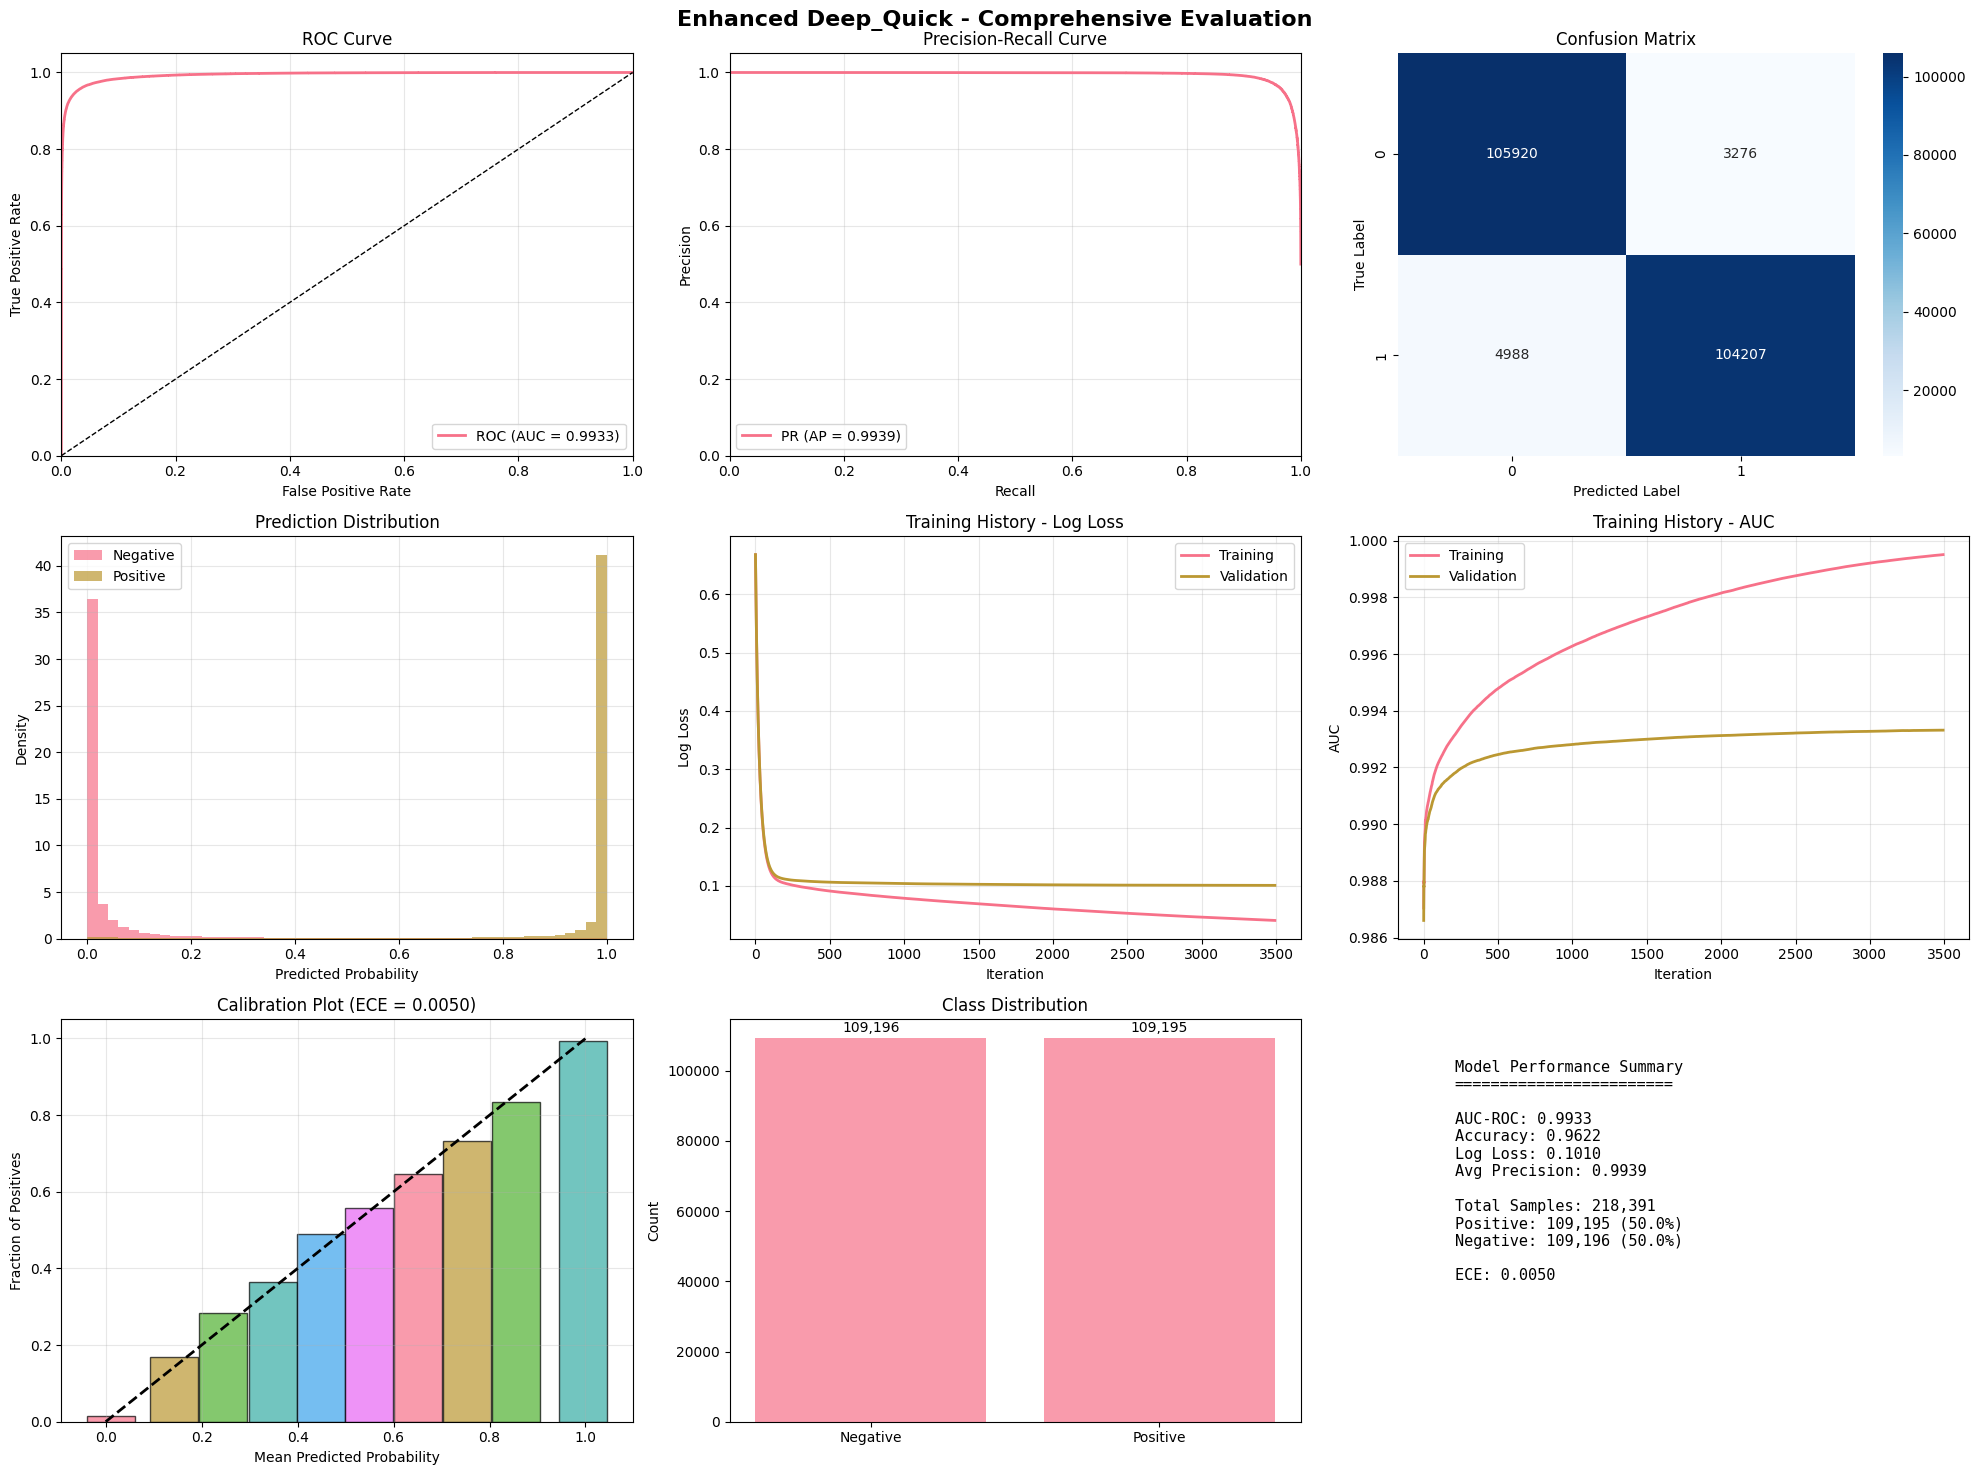


=== Enhanced Evaluation: Enhanced Deep Model (Quick) ===
🎯 Performance Metrics:
   Log Loss:        0.101027
   AUC-ROC:         0.993316
   Accuracy:        0.962160
   Avg Precision:   0.993900
🏆 Outstanding! AUC > 0.99 achieved!
⭐ Great! Accuracy > 96% achieved!

📊 Training Summary:
   Best iteration:  3327
   Final log loss:  0.100991
   Train log loss:  0.042727

📋 Classification Report:
              precision    recall  f1-score   support

           0     0.9550    0.9700    0.9625    109196
           1     0.9695    0.9543    0.9619    109195

    accuracy                         0.9622    218391
   macro avg     0.9623    0.9622    0.9622    218391
weighted avg     0.9623    0.9622    0.9622    218391

 Plots saved to: D:NLP_Cache\enhanced_results\Enhanced Deep Model (Quick)_detailed_evaluation.png


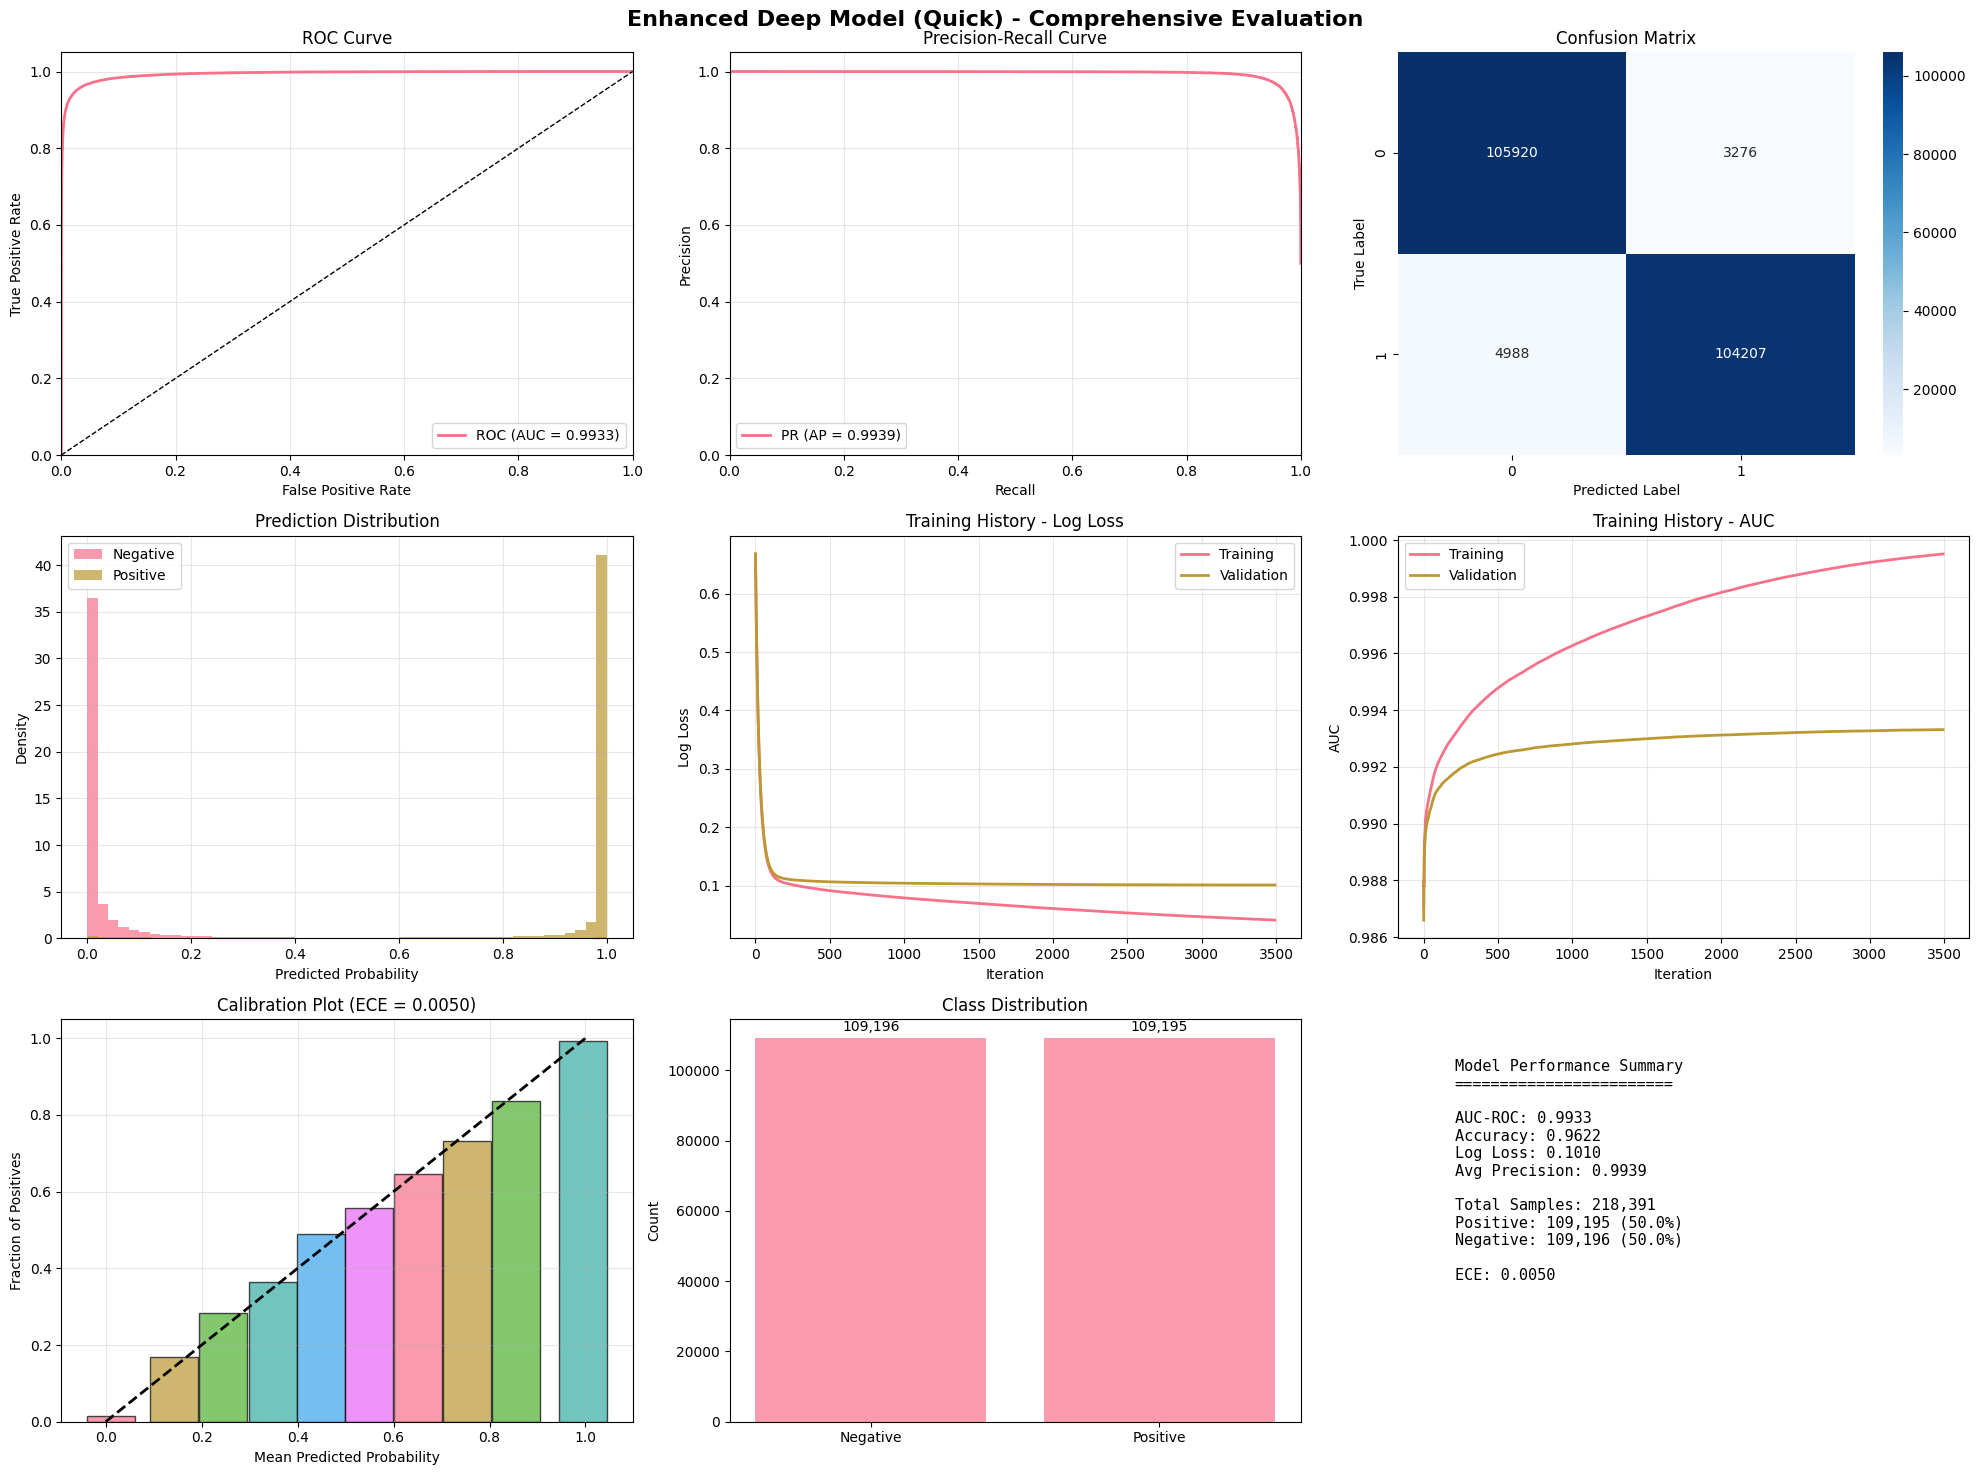

✅ Experiment completed!
🎯 AUC: 0.993316
📉 Log Loss: 0.101027
🎯 Accuracy: 0.962160


In [17]:
# %% "NEW" - FIXED VERSION (τρέξε αυτό μετά τον παραπάνω κώδικα)
print("'NEW'🧪 Experiment : Deep Model")

# Περισσότερα features
X_train_more, X_val_more, selector_more, scaler_more = feature_selection_and_scaling(
    X_combined, y, is_train, n_features=400, force_reload=False
)

y_train = y[is_train]
y_val = y[~is_train]

# Χρήση της ΔΙΟΡΘΩΜΕΝΗΣ συνάρτησης
print("🔄 Using Quick Enhanced Training (No Retraining)")
model, evals, metrics = train_enhanced_xgboost_quick(
    X_train_more, X_val_more, y_train, y_val,
    experiment_name="deep_quick", 
    num_rounds=10000,  # Λιγότερες iterations
    early_stopping=50,
    use_lr_scheduler= True  # Απενεργοποίηση LR scheduler
)

# Evaluation
results = evaluate_model_enhanced(
    model, X_val_more, y_val, evals,
    "Enhanced Deep Model (Quick)", 
    create_plots=True
)


print(f"✅ Experiment completed!")
print(f"🎯 AUC: {results['auc']:.6f}")
print(f"📉 Log Loss: {results['logloss']:.6f}")
print(f"🎯 Accuracy: {results['accuracy']:.6f}")

In [12]:
# %% [markdown]
# ## 11. 🔮 Test Data Prediction Pipeline
# 
# **Εδώ θα φτιάξουμε predictions για τα unseen test data**

# %%
def load_test_data(test_csv_path):
    """Φόρτωση test data από CSV"""
    print("📂 Loading test data...")
    
    test_df = pd.read_csv(test_csv_path)
    print(f"✅ Test data loaded: {test_df.shape}")
    print(f"   Columns: {len(test_df.columns)}")
    
    # Εμφάνιση πρώτων γραμμών για έλεγχο
    print("\n📋 Test data preview:")
    print(test_df.head(2))
    
    return test_df

def create_test_specter_features(test_df, specter_emb_pca, pid_to_idx, force_reload=False):
    """Δημιουργία SPECTER features για test data"""
    
    cache_file = "test_specter_features.npy"
    
    if not force_reload and cache_exists(cache_file):
        print("📁 Loading test SPECTER features from cache...")
        return load_from_cache(cache_file)
    
    print("🔄 Creating test SPECTER features...")
    
    # Mapping των test PIDs σε indices
    test_idxs_pid1 = test_df['citing'].map(pid_to_idx).astype(np.int32).values
    test_idxs_pid2 = test_df['cited'].map(pid_to_idx).astype(np.int32).values
    
    # Έλεγχος για missing PIDs
    missing_citing = pd.isna(test_df['citing'].map(pid_to_idx)).sum()
    missing_cited = pd.isna(test_df['cited'].map(pid_to_idx)).sum()
    
    if missing_citing > 0 or missing_cited > 0:
        print(f"⚠️  Missing PIDs - Citing: {missing_citing}, Cited: {missing_cited}")
        # Αντικατάσταση missing values με 0 (ή μπορείς να χρησιμοποιήσεις άλλη στρατηγική)
        test_idxs_pid1 = np.nan_to_num(test_idxs_pid1, nan=0).astype(np.int32)
        test_idxs_pid2 = np.nan_to_num(test_idxs_pid2, nan=0).astype(np.int32)
    
    # Δημιουργία features όπως στο training
    extractor = MemoryEfficientFeatureExtractor()
    
    X_emb1_test = specter_emb_pca[test_idxs_pid1].astype(np.float32)
    X_emb2_test = specter_emb_pca[test_idxs_pid2].astype(np.float32)
    
    # Χρήση chunked processing
    X_hadamard_test = extractor.process_embeddings_chunked(X_emb1_test, X_emb2_test, 'hadamard')
    X_abs_diff_test = extractor.process_embeddings_chunked(X_emb1_test, X_emb2_test, 'abs_diff')
    X_cosine_test = extractor.process_embeddings_chunked(X_emb1_test, X_emb2_test, 'cosine')
    
    # Πρόσθετα statistical features
    X_dot_test = (X_emb1_test * X_emb2_test).sum(axis=1).reshape(-1, 1)
    X_l2_dist_test = np.linalg.norm(X_emb1_test - X_emb2_test, axis=1).reshape(-1, 1)
    
    # Συνδυασμός όλων των SPECTER features
    test_specter_features = np.hstack([
        X_emb1_test, X_emb2_test, X_hadamard_test, X_abs_diff_test, 
        X_cosine_test, X_dot_test, X_l2_dist_test
    ]).astype(np.float16)
    
    del X_emb1_test, X_emb2_test, X_hadamard_test, X_abs_diff_test, X_cosine_test, X_dot_test, X_l2_dist_test
    gc.collect()
    
    # Save to cache
    save_to_cache(test_specter_features, cache_file)
    
    return test_specter_features

def create_test_w2v_features(test_df, pid_to_idx, force_reload=False):
    """Δημιουργία W2V features για test data"""
    
    cache_file = "test_w2v_features.npy"
    
    if not force_reload and cache_exists(cache_file):
        print("📁 Loading test W2V features from cache...")
        return load_from_cache(cache_file)
    
    print("🔄 Creating test W2V features...")
    
    # Φόρτωση W2V embeddings
    data = np.load(r'D:\NLP\Features_XL\embeddings_abstracts\abstract_w2v_embeds.npz')
    mean_embeds = data['mean_embeds'].astype(np.float32)
    
    # PCA με ίδιες παραμέτρους όπως στο training
    pca_w2v = PCA(n_components=24, random_state=42)
    mean_embeds_pca = pca_w2v.fit_transform(mean_embeds).astype(np.float16)
    
    # Mapping test PIDs
    test_idxs_pid1 = test_df['citing'].map(pid_to_idx).fillna(0).astype(np.int32).values
    test_idxs_pid2 = test_df['cited'].map(pid_to_idx).fillna(0).astype(np.int32).values
    
    X_w2v1_test = mean_embeds_pca[test_idxs_pid1]
    X_w2v2_test = mean_embeds_pca[test_idxs_pid2]
    
    # Υπολογισμός similarities
    dot_w2v_test = (X_w2v1_test * X_w2v2_test).sum(axis=1)
    norm1_test = np.linalg.norm(X_w2v1_test, axis=1)
    norm2_test = np.linalg.norm(X_w2v2_test, axis=1)
    cosine_w2v_test = dot_w2v_test / (norm1_test * norm2_test + 1e-8)
    l1_w2v_test = np.abs(X_w2v1_test - X_w2v2_test).sum(axis=1)
    l2_w2v_test = np.linalg.norm(X_w2v1_test - X_w2v2_test, axis=1)
    
    # Συνδυασμός features
    test_w2v_features = np.hstack([
        X_w2v1_test, X_w2v2_test,
        X_w2v1_test * X_w2v2_test,  # hadamard
        np.abs(X_w2v1_test - X_w2v2_test),  # abs diff
        dot_w2v_test.reshape(-1, 1),
        cosine_w2v_test.reshape(-1, 1),
        l1_w2v_test.reshape(-1, 1),
        l2_w2v_test.reshape(-1, 1)
    ]).astype(np.float16)
    
    del mean_embeds, mean_embeds_pca, X_w2v1_test, X_w2v2_test
    gc.collect()
    
    # Save to cache
    save_to_cache(test_w2v_features, cache_file)
    
    return test_w2v_features

def prepare_test_csv_features(test_df):
    """Προετοιμασία CSV features για test data"""
    print("🔄 Preparing test CSV features...")
    
    # Ίδια features όπως στο training
    selected_feats = [
        'citation_G_adamic_adar', 'specter_cosine', 'specter_dot',
        'specter_l1', 'specter_l2', 'author_node2vec_cosine',
        'author_node2vec_dot', 'author_node2vec_l2', 'citation_G_jaccard',
        'citation_G_hub_depressed', 'tfidf_similarity', 'citing_degree',
        'cosine_auth_svd_koz', 'bertopic_features_0', 'bertopic_features_1',
        'bertopic_features_2', 'triangles_through_edge_h2',
    ]
    
    # Επιλογή μόνο των features που υπάρχουν στο test dataset
    available_feats = [f for f in selected_feats if f in test_df.columns]
    missing_feats = [f for f in selected_feats if f not in test_df.columns]
    
    print(f"✅ Available features: {len(available_feats)}")
    if missing_feats:
        print(f"⚠️  Missing features: {missing_feats}")
    
    # Εξαγωγή features
    test_csv_features = test_df[available_feats].values.astype(np.float32)
    
    # Έλεγχος για NaN values
    nan_count = np.isnan(test_csv_features).sum()
    if nan_count > 0:
        print(f"⚠️  Found {nan_count} NaN values, filling with 0")
        test_csv_features = np.nan_to_num(test_csv_features, nan=0.0)
    
    return test_csv_features

def predict_test_data(test_csv_path, model, selector, scaler, 
                     specter_emb_pca, pid_to_idx, 
                     output_path="test_predictions.csv",
                     force_reload=False):
    """Complete pipeline για test predictions"""
    
    print("🎯 Starting test prediction pipeline...")
    
    # 1. Φόρτωση test data
    test_df = load_test_data(test_csv_path)
    
    # 2. Δημιουργία features
    print("\n🔧 Creating test features...")
    test_specter_features = create_test_specter_features(test_df, specter_emb_pca, pid_to_idx, force_reload)
    test_w2v_features = create_test_w2v_features(test_df, pid_to_idx, force_reload)
    test_csv_features = prepare_test_csv_features(test_df)
    
    print(f"   - SPECTER features: {test_specter_features.shape}")
    print(f"   - W2V features: {test_w2v_features.shape}")
    print(f"   - CSV features: {test_csv_features.shape}")
    
    # 3. Συνδυασμός features (ίδια σειρά όπως στο training)
    print("\n🔗 Combining test features...")
    X_test_combined = np.hstack([
        test_specter_features,
        test_csv_features,
        test_w2v_features
    ]).astype(np.float32)
    
    print(f"   - Combined test features: {X_test_combined.shape}")
    
    # 4. Feature selection και scaling (χρήση των trained models)
    print("\n🎛️  Applying feature selection and scaling...")
    X_test_selected = selector.transform(X_test_combined)
    X_test_scaled = scaler.transform(X_test_selected).astype(np.float32)
    
    print(f"   - Final test features: {X_test_scaled.shape}")
    
    # 5. Predictions
    print("\n🔮 Making predictions...")
    test_dmatrix = xgb.DMatrix(X_test_scaled)
    predictions = model.predict(test_dmatrix)
    
    # 6. Δημιουργία output DataFrame
    print(f"\n💾 Saving predictions to {output_path}...")
    results_df = pd.DataFrame({
        'ID': range(len(predictions)),
        'Label': predictions
    })
    
    # Αποθήκευση
    results_df.to_csv(output_path, index=False)
    
    print(f"✅ Predictions completed!")
    print(f"   - Total predictions: {len(predictions)}")
    print(f"   - Mean prediction: {predictions.mean():.4f}")
    print(f"   - Min prediction: {predictions.min():.4f}")
    print(f"   - Max prediction: {predictions.max():.4f}")
    print(f"   - Predictions > 0.5: {(predictions > 0.5).sum()}")
    
    # Cleanup
    del test_specter_features, test_w2v_features, test_csv_features, X_test_combined
    gc.collect()
    
    return results_df, predictions

print("✓ Test prediction functions defined")



✓ Test prediction functions defined


In [13]:
# %% [markdown]
# ## 12. 🚀 Run Test Predictions
# 
# **Τρέχε αυτό το cell για να κάνεις predictions στα test data**

# %%
# Ορισμός paths
TEST_CSV_PATH = r"D:\NLP\Features_XL\test\full_test_correct_h2_features.csv"
OUTPUT_PATH = CACHE_DIR / "test_predictions_2.csv"

# Επιλογή του μοντέλου που θες να χρησιμοποιήσεις
# Αλλαγή εδώ αν θες διαφορετικό μοντέλο
selected_model = bst_deep  # ή bst_fast, bst_deep
selected_selector = selector_more  # ή selector_fast
selected_scaler = scaler_more  # ή scaler_fast

print(f"📋 Selected model: More Features Model")
print(f"🎯 Test file: {TEST_CSV_PATH}")
print(f"💾 Output file: {OUTPUT_PATH}")

# Εκτέλεση predictions
results_df, predictions = predict_test_data(
    test_csv_path=TEST_CSV_PATH,
    model=selected_model,
    selector=selected_selector,
    scaler=selected_scaler,
    specter_emb_pca=specter_emb_pca,
    pid_to_idx=pid_to_idx,
    output_path=OUTPUT_PATH,
    force_reload=False  # Άλλαξε σε True αν θες fresh calculation
)

# Εμφάνιση sample από τα αποτελέσματα
print(f"\n📊 Sample predictions:")
print(results_df.head(10))

print(f"\n🎉 Predictions saved to: {OUTPUT_PATH}")

# %% [markdown]
# ## 13. 📈 Prediction Analysis (Optional)
# 
# **Ανάλυση των predictions για quality check**

# %%
# Ανάλυση των predictions
print("📈 Prediction Analysis:")
print(f"   Total samples: {len(predictions)}")
print(f"   Mean probability: {predictions.mean():.4f}")
print(f"   Std probability: {predictions.std():.4f}")
print(f"   Median probability: {np.median(predictions):.4f}")

# Distribution analysis
prob_ranges = [
    (0.0, 0.1, "Very Low (0.0-0.1)"),
    (0.1, 0.3, "Low (0.1-0.3)"),
    (0.3, 0.7, "Medium (0.3-0.7)"),
    (0.7, 0.9, "High (0.7-0.9)"),
    (0.9, 1.0, "Very High (0.9-1.0)")
]

print(f"\n📊 Prediction Distribution:")
for min_val, max_val, label in prob_ranges:
    count = ((predictions >= min_val) & (predictions < max_val)).sum()
    if min_val == 0.9:  # για το τελευταίο range να περιλαμβάνει και το 1.0
        count = ((predictions >= min_val) & (predictions <= max_val)).sum()
    percentage = (count / len(predictions)) * 100
    print(f"   {label}: {count:,} ({percentage:.1f}%)")

# Top predictions
print(f"\n🔝 Top 10 predictions:")
top_indices = np.argsort(predictions)[-10:][::-1]
for i, idx in enumerate(top_indices):
    print(f"   {i+1:2d}. ID {idx}: {predictions[idx]:.4f}")

print(f"\n✅ Analysis complete!")

#

📋 Selected model: More Features Model
🎯 Test file: D:\NLP\Features_XL\test\full_test_correct_h2_features.csv
💾 Output file: D:NLP_Cache\test_predictions_2.csv
🎯 Starting test prediction pipeline...
📂 Loading test data...
✅ Test data loaded: (106692, 92)
   Columns: 92

📋 Test data preview:
   citing  cited  citing_author_mean_pagerank  cited_author_mean_pagerank  \
0   34977  59394                     0.000074                    0.000099   
1   22518  46602                     0.000016                    0.000011   

   citing_author_max_pagerank  cited_author_max_pagerank  \
0                    0.000142                   0.000159   
1                    0.000032                   0.000013   

   citing_author_mean_degree  cited_author_mean_degree  \
0                       85.0                      96.0   
1                       22.5                       6.0   

   max_citing_topic_author_dom_cosine  mean_citing_topic_author_dom_cosine  \
0                                 0.0      